<div style="width:90%; margin:0 auto; background-color:#F0F0F0; padding:20px; border-radius:8px; font-family:Arial, sans-serif">

<div style="display:flex; align-items:center; justify-content:space-between; margin-bottom:15px">
    <div style="width:100px; height:100px">
        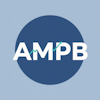
    </div>
    <div style="text-align:center; margin-bottom:20px">
        <h1 style="color:#9E0B0F; font-size:26px; margin-bottom:5px">Análisis de modelos predictivos en bolsa</h1>
        <h3 style="color:#D64550; font-size:22px; margin-top:0">Copyright (C) 2024-2025 MegaStorm Systems</h3>
    </div>
    <div style="width:192px; height:59px">
        <p style="max-width:100%; max-height:100%">
    </div>
</div>

<div style="width:60%; margin:0 auto; background-color:#E8E8E8; padding:20px; border-radius:10px; border:1px solid #D0D0D0; margin-bottom:20px; color:#333333; line-height:1.5; box-shadow:0 2px 4px rgba(0,0,0,0.05)">
    <p style="margin:0; font-size:15px">    
    This software is provided "as-is", without any express or implied<br>
    warranty. In no event will the authors be held liable for any damages<br>
    arising from the use of this software.<br><br>
    Permission is granted to anyone to use this software for any purpose,<br>
    including commercial applications, and to alter it and redistribute it<br>
    freely, subject to the following restrictions:<br><br>
    1. The origin of this software must not be misrepresented; you must not<br>
    claim that you wrote the original software. If you use this software<br>
    in a product, an acknowledgment in the product documentation would be<br>
    appreciated but is not required.<br>
    2. Altered source versions must be plainly marked as such, and must not be<br>
    misrepresented as being the original software.<br>
    3. This notice may not be removed or altered from any source distribution.
    </p>
</div>

<div style="text-align:center">
    <h2 style="font-size:24px; color:#9E0B0F; margin:0">Predictor Prophet v2.3</h2>
</div>

</div>

In [ ]:
# Importar librerías
import os
import argparse
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet.forecaster').setLevel(logging.ERROR)
logging.getLogger('stan').setLevel(logging.ERROR)
import cmdstanpy
cmdstanpy_logger = logging.getLogger('cmdstanpy')
cmdstanpy_logger.setLevel(logging.ERROR)
cmdstanpy_logger.propagate = False
logging.disable(logging.INFO)

import pandas as pd
import numpy as np
from prophet import Prophet
from itertools import product
import time
from ampblib import AMPBConfig, processData, generateEvaluation, createReport, reverseTransformPredictions, createModelIdentity

In [ ]:
# 0. PARÁMETROS CONFIGURABLES

model_name = "Prophet"
model_version = "v2.3"

# Por defecto, permite ejecucion interactiva
default_transformation = "None" # "None", "Log", "RetLog", "YeoJohnson"

# Estos son fijos e internos, no los exponemos
nombre_archivo = "NVDA_2015-01-05_2025-05-23_SA.csv"
test_size = 60              # Número de días para el conjunto de test
optimize_params = True      # True para optimizar hiperparámetros con grid search, False para usar valores fijos
run_backtesting = True      # True para Backtesting con Walk-Forward y False para no realizar este test
retrain_interval = 1        # Reentrenar modelo completo cada n días en backtesting. 5 es un valor adecuado, acelera la velocidad a cambio de perder un ~6% de rendimiento.

# Hiperparámetros fijos para Prophet
# transform = "None" con MAE=1.4578
# transform = "Log" con MAE=0.0547
# transform = "YeoJohnson" con MAE=0.0560
fixed_params1 = { 
    'changepoint_prior_scale': 1.0,
    'seasonality_prior_scale': 0.1,
    'holidays_prior_scale': 0.1,
    'seasonality_mode': 'additive',
    'n_changepoints': 50,
    'changepoint_range': 0.95,
    'interval_width': 0.8,
    'daily_seasonality': 'auto',
    'yearly_seasonality': 'auto', 
    'weekly_seasonality': 'auto'
}  

# transform = "RetLog" con MAE=0.0207
fixed_params2 = { 
    'changepoint_prior_scale': 0.3,
    'seasonality_prior_scale': 0.1,
    'holidays_prior_scale': 0.1,
    'seasonality_mode': 'additive',
    'n_changepoints': 50,
    'changepoint_range': 0.9,
    'interval_width': 0.8,
    'daily_seasonality': 'auto',
    'yearly_seasonality': 'auto', 
    'weekly_seasonality': 'auto'
}  

# Seleccionar los parametros según transformación
fixed_params = fixed_params2 if default_transformation == "RetLog" else fixed_params1

# Argumentos de línea de comandos  
if AMPBConfig.INTERACTIVE:
    transformation = default_transformation
else:
    parser = argparse.ArgumentParser(description='Ejecuta modelo Prophet.')
    parser.add_argument('--transformation', type=str, default=default_transformation, choices=['None', 'Log', 'RetLog', 'YeoJohnson'])
    args = parser.parse_args()
    transformation = args.transformation

AMPBConfig.printHeader(title=f"Predictor {model_name} {model_version}", testsize=test_size, 
                     optimize=optimize_params, backtesting=run_backtesting, transform=transformation,
                     exogscaling="None", exogsetid=0)

In [ ]:
# 1. CARGA Y PREPARACIÓN DE DATOS
datos = pd.read_csv(nombre_archivo)

# Seleccionar columnas relevantes
mandatory_vars = ['Date','Close', 'Trend']

df = datos[mandatory_vars]

# Convertir fechas a datetime
df['Date'] = pd.to_datetime(df['Date'])  

# Verificar y mostrar estadísticas básicas de los datos
print(f"Datos en crudo cargados: {len(df)} registros de {df['Date'].min()} a {df['Date'].max()}.")

# Detectar valores faltantes
missing = df.isna().sum()
missing = missing[missing > 0]

if not missing.empty:
    total_before = len(df)
    print("Valores faltantes por columna (se borrarán estas filas):")
    for col, cnt in missing.items():
        print(f"  • {col}: {cnt} valores faltantes")
    df = df.dropna().reset_index(drop=True)
    total_after = len(df)
    removed = total_before - total_after
    print(f"\nFilas borradas: {removed}")
else:
    print("No se encontraron valores faltantes.")

# Poner Date como indice
df.set_index('Date', inplace=True)
#df = df.asfreq('B', method='pad')  # Se asume que se trata de datos bursátiles (días hábiles) y rellena con valores previos

print(f"\nDatos cargados: {AMPBConfig.COLOR_VALUE}{len(df)}{AMPBConfig.COLOR_RESET} registros. Prophet no utiliza variables exógenas.") 


In [ ]:
# 2. DIVISIÓN ENTRE ENTRENAMIENTO Y TEST

# 2A. Se utiliza el 90% de los datos para entrenamiento y el 10% para test
#split_index = int(len(df) * 0.90)
#df_train = df.iloc[:split_index].copy()
#df_test = df.iloc[split_index:].copy()

# 2B. Separamos datos de entrenamiento y de test por fecha
#split_date = pd.Timestamp('2024-12-01')
#df_train = df.loc[:split_date].copy()
#df_test = df.loc[split_date:].copy()

# 2C. Separamos por numero de dias.
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

# Guardar valores originales (inmutables para referencia futura)
y_train_original = df_train['Close'].copy()
y_test_original = df_test['Close'].copy()

# Variable a predecir: precio de cierre
y_train = df_train['Close']
y_test = df_test['Close']

print(f"\nDatos divididos:")
print(f"  Entrenamiento: {AMPBConfig.COLOR_VALUE}{len(y_train)}{AMPBConfig.COLOR_RESET} filas (hasta {y_train.index[-1].date()})")
print(f"  Test:          {AMPBConfig.COLOR_VALUE}{len(y_test)}{AMPBConfig.COLOR_RESET} filas (desde {y_test.index[0].date()})")

In [ ]:
# 3. PROCESAR DATOS: TRANSFORMACIONES, ESCALADO, ALINEACION Y ANALISIS DE CALIDAD
# Bajo determinadas circunstancias, puede abortar la ejecucion.
processing_results = processData(
    y_train, y_test, None, None,
    y_train_original, y_test_original, None, None,
    df_test, None, transformation, None,
    winsorization_value=0,   
    analyze=False               # Sin exógenas, no hay nada que analizar
)
params_close = processing_results['params_close']
y_scaler = processing_results['y_scaler']
df_test_aligned = processing_results['df_test_aligned']
prediction_max_limit = processing_results['prediction_max_limit']

# Prophet requiere columnas 'ds' (fechas) y 'y' (valores)
# Usar los datos YA procesados (pueden haber cambiado de tamaño)
train_prophet = pd.DataFrame({
    'ds': y_train.index,
    'y': y_train.values
})

test_prophet = pd.DataFrame({
    'ds': y_test.index,
    'y': y_test.values
})

In [ ]:
# 4. OPTIMIZACIÓN DE HIPERPARÁMETROS DE PROPHET CON GRID SEARCH
if optimize_params:
    print("Buscando los mejores hiperparámetros para Prophet...")
    
    # Definir grid de hiperparámetros para optimizar
    param_grid = {
        'changepoint_prior_scale': [0.1, 0.3, 0.5, 0.8, 1.0],
        'seasonality_prior_scale': [0.1, 0.5, 1.0, 5.0, 10.0],
        'holidays_prior_scale': [0.1, 0.5, 1.0, 5.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative'],
        'n_changepoints': [15, 35, 50],  # Más puntos de cambio para volatilidad
        'changepoint_range': [0.8, 0.9, 0.95],  # Hasta dónde buscar cambios
        'interval_width': [0.8, 0.9, 0.95],  # Ancho del intervalo de confianza
    }
       
    # Generar todas las combinaciones posibles
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    best_mae = float('inf')
    best_params_found = None
    total_combinations = len(param_combinations)

    print(f"Evaluando {total_combinations} combinaciones de hiperparámetros...")

    for i, param_values in enumerate(param_combinations):
        progress_perc = (i + 1) / total_combinations * 100
        print(f" Optimización Prophet: {i+1}/{total_combinations} ({progress_perc:.1f}%)", end='\r', flush=True)
        
        # Crear diccionario de parámetros
        current_params = dict(zip(param_names, param_values))
        
        try:
            # Crear y entrenar modelo con todos los datos de entrenamiento
            model_temp = Prophet(**current_params)
            model_temp.fit(train_prophet)
            
            # Hacer predicción en los mismos datos de entrenamiento
            future_train = model_temp.make_future_dataframe(periods=0, freq='B')
            forecast_train = model_temp.predict(future_train)
            
            # Calcular MAE en entrenamiento
            train_predictions = forecast_train['yhat'].values
            train_actual = train_prophet['y'].values
            mae = np.mean(np.abs(train_predictions - train_actual))
            
            # Actualizar mejor modelo si es necesario
            if mae < best_mae:
                best_mae = mae
                best_params_found = current_params.copy()
                
        except Exception as e:
            # Si el modelo falla, continuar con la siguiente combinación
            continue

    print(f"\nMejor MAE en entrenamiento: {best_mae:.4f}")
    best_params = best_params_found

# 4B. USAR HIPERPARÁMETROS FIJOS
else:   
    # Usar hiperparámetros fijos
    best_params = fixed_params.copy()

# 4C. AJUSTE DE PROPHET
print("Ajustando modelo...")
best_model = Prophet(**best_params)
best_model.fit(train_prophet)
    
# Creamos el título (y su hash) y mostramos resultados
param_str = f"({best_params['changepoint_prior_scale']},{best_params['seasonality_prior_scale']},{best_params['holidays_prior_scale']},{best_params['n_changepoints']},{best_params['changepoint_range']},{best_params['interval_width']})"
model_title, model_hash = createModelIdentity(model_name, model_version, param_str, transformation, "None", "None")
print(f"\n{AMPBConfig.COLOR_INFO}Parametros para {model_name}{model_version}:{AMPBConfig.COLOR_RESET}")
print(f"Hiperparámetros utilizados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nTítulo: '{model_title}' con HashID: {model_hash}\n")


In [ ]:
# 5A. PREDICCIÓN Y EVALUACIÓN EN EL CONJUNTO DE TEST (VALIDACIÓN ESTÁTICA)
print(f"{AMPBConfig.COLOR_INFO}Validación Estática{AMPBConfig.COLOR_RESET}")

# Predicción del período de test completo
future_test = best_model.make_future_dataframe(periods=len(y_test), freq='B')
forecast_test = best_model.predict(future_test)

# Extraer solo las predicciones del período de test
forecast_scaled_transformed = forecast_test['yhat'].iloc[-len(y_test):].values
forecast_scaled_transformed = pd.Series(forecast_scaled_transformed, index=y_test.index)

# Aplicar pipeline de des-transformación
forecast_original = reverseTransformPredictions(
    forecast_scaled_transformed,
    y_train_original.iloc[-1],
    y_scaler,
    transformation, 
    params_close,
    prediction_max_limit
)

# Predicción día siguiente
next_day_date = y_test.index[-1] + pd.tseries.offsets.BDay(1)

# Crear dataframe que incluye el siguiente día
future_next = best_model.make_future_dataframe(periods=len(y_test) + 1, freq='B')
forecast_next = best_model.predict(future_next)

# Extraer la predicción del siguiente día (última predicción)
next_forecast_scaled_transformed = pd.Series([forecast_next['yhat'].iloc[-1]], index=[next_day_date])

next_day_forecast_original = reverseTransformPredictions(
    next_forecast_scaled_transformed, 
    y_test_original.iloc[-1], # Para la referencia del día siguiente, usar el último valor real del test
    y_scaler,
    transformation,
    params_close,
    prediction_max_limit
).iloc[0]

In [ ]:
# 5B. EVALUACIÓN Y GRÁFICAS
# Evaluación de validación estática
sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc = generateEvaluation(
    y_test_original, forecast_original, df_test_aligned, model_title, model_hash, 
    next_day_date, next_day_forecast_original, "Static Validation")

# Guardar reporte
createReport(model_name, "SV", f"{transformation}", 
             model_title, model_hash, sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc)


In [ ]:
# 6. EVALUACIÓN CON CROSS VALIDATION (VALIDACIÓN CRUZADA)
# Opcional, no disponible en este modelo.

In [ ]:
# 7A. MODO DE BACKTESTING: PREDICCIÓN DÍA A DÍA (VALIDACIÓN BACKTESTING)
if run_backtesting:    
    model_title_backtest = f'{model_title} (Backtesting [{retrain_interval}d])'
    print(f"\n{AMPBConfig.COLOR_INFO}Modo Backtesting con Walk-Forward (Retrain cada {retrain_interval} días){AMPBConfig.COLOR_RESET}")
    
    # Inicializar historiales (solo serie temporal, sin exógenas)
    history_y = y_train.copy()              # Datos transformados/escalados para el modelo
    history_y_original = y_train_original.copy()  # Valores originales para referencias
    
    predictions_original_bt = []
    model_bt = None  # Modelo que se reutilizará entre reentrenamientos
    
    bt_start = time.time()
    for t in range(len(y_test)):
        print(f" Backtesting: {t+1}/{len(y_test)}", end='')
        
        # Reentrenar el modelo cuando sea necesario
        if t % retrain_interval == 0:   
            print(f" [Reentrenando...]", end='')
            
            # Crear DataFrame Prophet con historial actual
            history_prophet = pd.DataFrame({
                'ds': history_y.index,
                'y': history_y.values
            })
            
            # Entrenar modelo Prophet
            model_bt = Prophet(**best_params)
            model_bt.fit(history_prophet)
            print(f" [✓]", end='')
        
        print(f"")  # Nueva línea
        
        # Predecir 1 paso adelante (Prophet)
        future_step = model_bt.make_future_dataframe(periods=1, freq='B')
        forecast_step = model_bt.predict(future_step)
        
        # Extraer la predicción del siguiente paso
        forecast_step_scaled_transformed = pd.Series([forecast_step['yhat'].iloc[-1]], index=[y_test.index[t]])
        
        # Des-transformar usando pipeline centralizado 
        reference_val = history_y_original.iloc[-1]
        forecast_step_original = reverseTransformPredictions(
            forecast_step_scaled_transformed,
            reference_val,
            y_scaler,
            transformation,
            params_close,
            prediction_max_limit
        ).iloc[0]
                
        # Guardar predicción
        predictions_original_bt.append(forecast_step_original)
        
        # Actualizar historiales con datos reales del día t (solo serie temporal)
        history_y = pd.concat([history_y, y_test.iloc[t:t+1]])
        history_y_original = pd.concat([history_y_original, pd.Series([y_test_original.iloc[t]], index=[y_test_original.index[t]])])
    
    # Estadísticas de reentrenamiento
    total_retrains = (len(y_test) + retrain_interval - 1) // retrain_interval   
    print(f" Backtesting completado en {time.time() - bt_start:.1f}s")
    print(f" Reentrenamientos realizados: {total_retrains} (cada {retrain_interval} días)\n")
    
    # Crear Serie con predicciones del backtesting
    forecast_backtest_original = pd.Series(predictions_original_bt, index=y_test_original.index)


In [ ]:
# 7B. MODO DE BACKTESTING: PREDICCIÓN SIGUIENTE DÍA
if run_backtesting:
    # Predicción del siguiente día usando el último modelo del backtesting
    future_next_bt = model_bt.make_future_dataframe(periods=1, freq='B')
    forecast_next_bt = model_bt.predict(future_next_bt)
    
    # Extraer predicción del siguiente día
    next_forecast_scaled_transformed_bt = pd.Series([forecast_next_bt['yhat'].iloc[-1]], 
                                                   index=[next_day_date])
    
    next_day_forecast_val_bt_original = reverseTransformPredictions(
        next_forecast_scaled_transformed_bt, 
        history_y_original.iloc[-1], # Predicción para el día siguiente usando el último modelo del backtesting
        y_scaler, 
        transformation, 
        params_close,
        prediction_max_limit
    ).iloc[0]


In [ ]:
# 7C. MODO DE BACKTESTING: EVALUACIÓN Y GRÁFICAS
if run_backtesting:
    # Evaluación del backtesting
    bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc = generateEvaluation(
        y_test_original, 
        forecast_backtest_original, 
        df_test_aligned, 
        model_title_backtest, 
        model_hash,
        next_day_date, 
        next_day_forecast_val_bt_original, 
        "Backtesting"
    )

    # Guardar informe del backtesting
    createReport(model_name, "BT", f"{transformation}", 
                 model_title, model_hash, bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc)